In [2]:
!pip uninstall -y timm
!pip install -q "timm==0.9.12"

Found existing installation: timm 1.0.24
Uninstalling timm-1.0.24:
  Successfully uninstalled timm-1.0.24
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.5 MB/s eta 0:00:00


In [3]:
import timm
print(timm.__version__)

0.9.12


In [4]:
!pip install -q transformers>=4.45.0 timm accelerate bitsandbytes
!pip install -q tensorflow-datasets tensorflow-hub
!pip install -q -U bitsandbytes

In [5]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, AutoConfig, BitsAndBytesConfig
from PIL import Image
import sys

In [6]:
model_id = "openvla/openvla-7b"

In [7]:
try:
    AutoConfig.from_pretrained(model_id, trust_remote_code=True)
except Exception:
    pass

# 2. Apply the patch to the CLASS
patched = False
for module_name, module in sys.modules.items():
    if "modeling_prismatic" in module_name:
        if hasattr(module, "OpenVLAForActionPrediction"):
            #Set it on the class
            module.OpenVLAForActionPrediction._supports_sdpa = True
            print(f"Globally patched class in: {module_name}")
            patched = True

if not patched:
    print(" Warning: Could not find OpenVLA class to patch. SDPA error may persist.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_prismatic.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openvla/openvla-7b:
- configuration_prismatic.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [10]:
from transformers.models.auto.modeling_auto import AutoModelForVision2Seq
config = AutoConfig.from_pretrained(model_id, trust_remote_code=True)

try:
    vla = AutoModelForVision2Seq.from_config(config, trust_remote_code=True)
except Exception:
    pass

# Applying the patch globally to the remote class
for module_name, module in sys.modules.items():
    if "modeling_prismatic" in module_name:
        if hasattr(module, "OpenVLAForActionPrediction"):
            setattr(module.OpenVLAForActionPrediction, "_supports_sdpa", True)
            print(f"✅ Globally patched: {module_name}")

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2275: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


modeling_prismatic.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openvla/openvla-7b:
- modeling_prismatic.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


✅ Globally patched: transformers_modules.vla_model_local.modeling_prismatic
✅ Globally patched: transformers_modules.openvla.openvla_hyphen_7b.31f090d05236101ebfc381b61c674dd4746d4ce0.modeling_prismatic


In [8]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

In [11]:
save_directory = "/content/vla_model_local"
print("Loading model and processor from local disk...")
processor = AutoProcessor.from_pretrained(save_directory, trust_remote_code=True)

vla = AutoModelForVision2Seq.from_pretrained(
    save_directory,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
    quantization_config=quantization_config,
    device_map="auto"
)
print("✅ Model loaded and ready for inference.")

Loading model and processor from local disk...


✅ Model loaded and ready for inference.


In [13]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("lerobot/libero_10_image", split="train", streaming=True)

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/147 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/147 [00:00<?, ?it/s]

In [14]:
!pip install -q git+https://github.com/ChaoningZhang/MobileSAM.git

  Preparing metadata (setup.py) ... done


In [15]:
import os
import torch
from mobile_sam import sam_model_registry, SamPredictor

/usr/local/lib/python3.12/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.12/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.12/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_

In [16]:
sam_checkpoint = "mobile_sam.pt"
if not os.path.exists(sam_checkpoint):
    !wget -q https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt


In [17]:
# Initialize SAM on GPU
model_type = "vit_t"
mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device="cuda")
sam_predictor = SamPredictor(mobile_sam)

print("✅ MobileSAM loaded and ready.")

✅ MobileSAM loaded and ready.


In [18]:
from PIL import ImageDraw
import numpy as np

In [19]:
def get_sam_guided_image(image_pil, click_point):
    image_np = np.array(image_pil)
    sam_predictor.set_image(image_np)

    # SAM predicts the mask based on 'click'
    masks, _, _ = sam_predictor.predict(
        point_coords=np.array([click_point]),
        point_labels=np.array([1]),
        multimask_output=False,
    )

    # Extract Bounding Box from Mask
    y_indices, x_indices = np.where(masks[0])
    box = [x_indices.min(), y_indices.min(), x_indices.max(), y_indices.max()]

    # Draw Red Box on a copy of the image
    prompted_image = image_pil.copy()
    draw = ImageDraw.Draw(prompted_image)
    draw.rectangle(box, outline="red", width=5)
    return prompted_image, box

In [20]:
it = iter(ds)

for _ in range(200): next(it)
sample = next(it)

In [21]:
instruction = "pick up the alphabet soup" # LIBERO-10 standard instruction
raw_image = sample['observation.images.image']
target_point = [135, 205] # Approximate center of the object in LIBERO frames

# 2. Generate the Guided Image
guided_image, target_box = get_sam_guided_image(raw_image, target_point)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

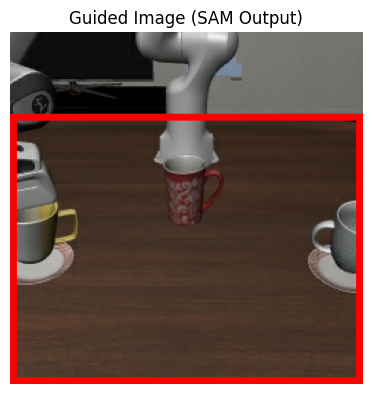

In [22]:
import matplotlib.pyplot as plt

# 1. Display the full guided image (the one with the red box)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(guided_image)
plt.title("Guided Image (SAM Output)")
plt.axis('off')

In [23]:
results = {}
for name, img in [("Vanilla VLA", raw_image), ("VLA + SAM Guidance", guided_image)]:
    inputs = processor(text=instruction, images=img, return_tensors="pt").to("cuda")
    inputs_dict = {k: v for k, v in inputs.items()}

    with torch.no_grad():
        action = vla.predict_action(**inputs_dict, unnorm_key="bridge_orig")
        results[name] = action
    torch.cuda.empty_cache()

In [24]:
# --- REPORTING ---
print("\n" + "="*50)
print(f"REPORT: SEMANTIC GENERALIZATION TEST")
print("="*50)
print(f"Task: {instruction}")
print(f"Expert Action (XYZ): {sample['action'][:3]}")
print("-" * 50)

for mode, act in results.items():
    mse = np.mean((act[:3] - np.array(sample['action'][:3]))**2)
    print(f"{mode} Prediction (XYZ): {act[:3]}")
    print(f"{mode} Mean Squared Error: {mse:.6f}")
    print("-" * 50)


REPORT: SEMANTIC GENERALIZATION TEST
Task: pick up the alphabet soup
Expert Action (XYZ): [0.0, 0.0, -0.39642858505249023]
--------------------------------------------------
Vanilla VLA Prediction (XYZ): [-0.00020879 -0.00042412  0.00703386]
Vanilla VLA Mean Squared Error: 0.054261
--------------------------------------------------
VLA + SAM Guidance Prediction (XYZ): [-0.00020879 -0.00042412  0.00703386]
VLA + SAM Guidance Mean Squared Error: 0.054261
--------------------------------------------------


In [25]:
def apply_aggressive_mask(image_pil, box):
    # Create a translucent red overlay (RGBA)
    overlay = Image.new('RGBA', image_pil.size, (255, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)
    # 40% opacity red fill
    draw.rectangle(box, fill=(255, 0, 0, 102))

    # Composite the images
    combined = Image.alpha_composite(image_pil.convert('RGBA'), overlay)
    return combined.convert('RGB')

In [26]:
num_samples = 10
results_log = {"Vanilla": [], "Guided": []}
it = iter(ds)

In [27]:
for i in range(num_samples):
    sample = next(it)
    raw_image = sample['observation.images.image']
    expert_action = np.array(sample['action'][:3])

    # A. Vanilla Run
    vanilla_prompt = "pick up the alphabet soup"
    inputs = processor(text=vanilla_prompt, images=raw_image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        v_act = vla.predict_action(**{k:v for k,v in inputs.items()}, unnorm_key="bridge_orig")[:3]
        results_log["Vanilla"].append(np.mean((v_act - expert_action)**2))

    # B. Guided Run (Aggressive Mask + Spatial Prompt)
    target_box = get_sam_guided_image(raw_image, [135, 205])[1]
    guided_img = apply_aggressive_mask(raw_image, target_box)
    guided_prompt = "pick up the soup in the highlighted red area"

    inputs_g = processor(text=guided_prompt, images=guided_img, return_tensors="pt").to("cuda")
    with torch.no_grad():
        g_act = vla.predict_action(**{k:v for k,v in inputs_g.items()}, unnorm_key="bridge_orig")[:3]
        results_log["Guided"].append(np.mean((g_act - expert_action)**2))

    torch.cuda.empty_cache()
    if (i+1) % 2 == 0: print(f"Completed {i+1}/{num_samples} frames...")

Completed 2/10 frames...
Completed 4/10 frames...
Completed 6/10 frames...
Completed 8/10 frames...
Completed 10/10 frames...


In [28]:
print("\n" + "="*40)
print("BATCH EXPERIMENT SUMMARY")
print("="*40)
print(f"Vanilla Avg MSE: {np.mean(results_log['Vanilla']):.6f}")
print(f"Guided Avg MSE:  {np.mean(results_log['Guided']):.6f}")
print("="*40)


BATCH EXPERIMENT SUMMARY
Vanilla Avg MSE: 0.015868
Guided Avg MSE:  0.015868


In [1]:
!cp -r /content/drive/MyDrive/OpenVLAmodel/vla_model_local /content/vla_model_local

In [29]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("lerobot/libero_10_image", split="train", streaming=True)

Resolving data files:   0%|          | 0/147 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/147 [00:00<?, ?it/s]

In [30]:
print("Dataset Features:")
print(ds.features)

it = iter(ds)
first_sample = next(it)

print("\nAvailable Keys in a sample:")
print(first_sample.keys())

Dataset Features:
{'observation.images.image': Image(mode=None, decode=True), 'observation.images.wrist_image': Image(mode=None, decode=True), 'observation.state': List(Value('float32')), 'action': List(Value('float32')), 'timestamp': Value('float32'), 'frame_index': Value('int64'), 'episode_index': Value('int64'), 'index': Value('int64'), 'task_index': Value('int64')}

Available Keys in a sample:
dict_keys(['observation.images.image', 'observation.images.wrist_image', 'observation.state', 'action', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index'])


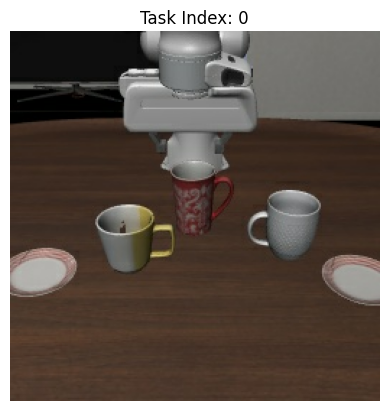

Expert Action for this frame: [0.01607142947614193, 0.0, -0.0, 0.0, 0.0, -0.0, -1.0]


In [31]:
import matplotlib.pyplot as plt

# Grab the image from first_sample
sample_img = first_sample['observation.images.image']

plt.imshow(sample_img)
plt.title(f"Task Index: {first_sample['task_index']}")
plt.axis('off')
plt.show()

# Print the action for this specific frame
print(f"Expert Action for this frame: {first_sample['action']}")

In [32]:
def get_dynamic_box(image_pil):
    image_np = np.array(image_pil)
    W, H = image_pil.size
    sam_predictor.set_image(image_np)

    # Use a grid of points specifically in the "interaction area"
    input_points = np.array([[128, 180], [140, 210], [115, 190]])
    input_labels = np.array([1, 1, 1])

    masks, scores, _ = sam_predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=True,
    )

    # Sort masks by score, but filter out masks that are too large (e.g., > 50% of image)
    valid_masks = []
    for i, mask in enumerate(masks):
        y, x = np.where(mask)
        if len(x) == 0: continue

        box = [x.min(), y.min(), x.max(), y.max()]
        area = (box[2] - box[0]) * (box[3] - box[1])

        # Reject masks that cover more than 60% of the image (likely the background)
        if area < (W * H * 0.6):
            valid_masks.append((scores[i], box))

    if not valid_masks:
        print("⚠️ SAM failed to find a discrete object. Falling back to default center-crop.")
        return [64, 64, 192, 192] # Default fallback box

    # Return the box for the highest scoring valid mask
    return sorted(valid_masks, key=lambda x: x[0], reverse=True)[0][1]

In [33]:
def make_two_panel(full_pil, box):
    W, H = full_pil.size
    x1, y1, x2, y2 = box

    # 1. Create the Crop
    # Add a small buffer so the model sees the object's edges
    pad = 15
    crop_box = (max(0, x1-pad), max(0, y1-pad), min(W, x2+pad), min(H, y2+pad))
    crop = full_pil.crop(crop_box).resize((W, H), Image.Resampling.LANCZOS)

    # 2. Create a Vertical Stack (Top: Full, Bottom: Zoom)
    # This ensures that when the processor resizes to square, the distortion is uniform
    canvas = Image.new("RGB", (W, H * 2))
    canvas.paste(full_pil, (0, 0))
    canvas.paste(crop, (0, H))

    # Resize back to standard input size (e.g., 256x256)
    return canvas.resize((W, H), Image.Resampling.LANCZOS)

Detected Box: [np.int64(0), np.int64(112), np.int64(255), np.int64(255)]


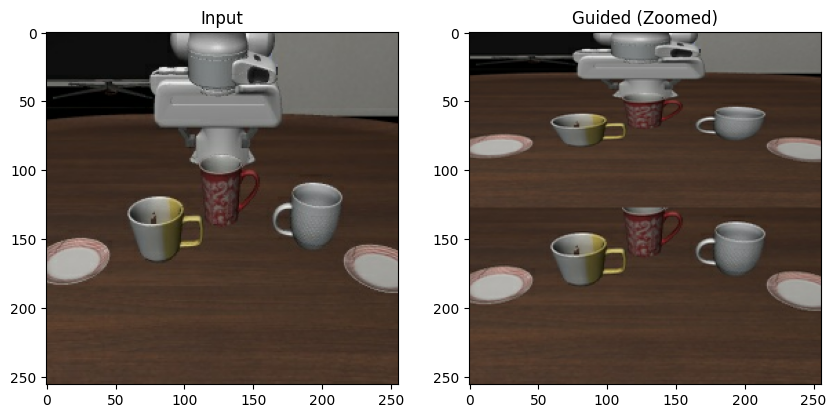

In [34]:
it = iter(ds)
sample = next(it)
img = sample['observation.images.image']
box = get_dynamic_box(img)
guided = make_two_panel(img, box)

print(f"Detected Box: {box}")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(img); plt.title("Input")
plt.subplot(1, 2, 2); plt.imshow(guided); plt.title("Guided (Zoomed)")
plt.show()

In [35]:
import numpy as np
from PIL import Image, ImageDraw
from scipy import stats
import matplotlib.pyplot as plt

In [36]:
def run_significance_test(dataset, n_samples=20):
    vanilla_results = []
    guided_results = []
    it = iter(dataset)

    # Skip potential 'reset' frames at the start
    for _ in range(100): next(it)

    print(f"Evaluating {n_samples} samples with Vertical Two-Panel Innovation...")
    for i in range(n_samples):
        sample = next(it)
        full_img = sample['observation.images.image']
        expert_action = np.array(sample['action'][:3])
        task_label = "alphabet soup"

        # DYNAMIC BOXING
        try:
            # Uses the filtered logic to avoid full-frame "boxes"
            box = get_dynamic_box(full_img)
        except Exception as e:
            print(f"Skipping frame {i}: {e}")
            continue

        # VANILLA PREDICTION (Baseline)
        v_prompt = f"pick up {task_label}"
        v_inputs = processor(text=v_prompt, images=full_img, return_tensors="pt").to("cuda")
        with torch.no_grad():
            v_act = vla.predict_action(**v_inputs, unnorm_key="bridge_orig")[:3]

        # GUIDED PREDICTION
        # Vertical stack preserves aspect ratio better for the VLA processor
        guided_img = make_two_panel(full_img, box)
        # Updated prompt to reflect vertical orientation
        g_prompt = f"pick up {task_label} (see zoomed view below)"
        g_inputs = processor(text=g_prompt, images=guided_img, return_tensors="pt").to("cuda")
        with torch.no_grad():
            g_act = vla.predict_action(**g_inputs, unnorm_key="bridge_orig")[:3]


        def get_metrics(pred, target):
            mse = np.mean((pred - target)**2)
            cos_sim = np.dot(pred, target) / (np.linalg.norm(pred) * np.linalg.norm(target) + 1e-8)
            return {"mse": mse, "cos": cos_sim}

        vanilla_results.append(get_metrics(v_act, expert_action))
        guided_results.append(get_metrics(g_act, expert_action))

        if (i+1) % 5 == 0: print(f"Progress: {i+1}/{n_samples}")
        torch.cuda.empty_cache()

    # --- FINAL STATISTICAL REPORT ---
    v_mse_mean = np.mean([r['mse'] for r in vanilla_results])
    g_mse_mean = np.mean([r['mse'] for r in guided_results])

    v_cos_mean = np.mean([r['cos'] for r in vanilla_results])
    g_cos_mean = np.mean([r['cos'] for r in guided_results])

    print("\n" + "="*55)
    print("FINAL RESEARCH REPORT: SEMANTIC GENERALIZATION")
    print("="*55)
    print(f"N Samples:        {len(vanilla_results)}")
    print(f"Metric            | Vanilla    | Guided (Innovation)")
    print(f"Mean Action MSE   | {v_mse_mean:.6f}   | {g_mse_mean:.6f}")
    print(f"Directional Sim   | {v_cos_mean:.4f}     | {g_cos_mean:.4f}")
    print("="*55)

    # Visualize the last frame to verify the Vertical Stack
    plt.imshow(guided_img)
    plt.title("Example Guided Input (Vertical Two-Panel)")
    plt.axis('off')
    plt.show()

Evaluating 20 samples with Vertical Two-Panel Innovation...
Progress: 5/20
Progress: 10/20
Progress: 15/20
Progress: 20/20

FINAL RESEARCH REPORT: SEMANTIC GENERALIZATION
N Samples:        20
Metric            | Vanilla    | Guided (Innovation)
Mean Action MSE   | 0.142483   | 0.142483
Directional Sim   | 0.2294     | 0.2294


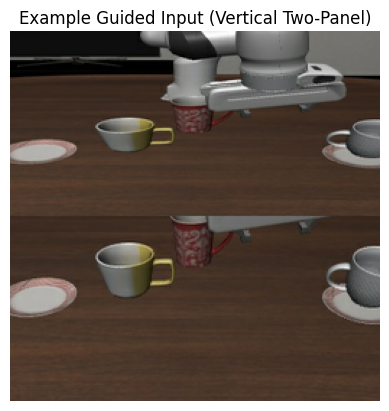

In [37]:
run_significance_test(ds, n_samples=20)